# Simple LSTM using segmented features as input

In [21]:
import sys
sys.path.append('../')

from estimators import Estimator, merged_config, plot_train_curve_comparison, plot_train_curve
import models
import losses
from datasets import IOVar
from sequences import load_sequences_from_pickle, Measurement
import matplotlib.pyplot as plt
import logging
import os
import matplotlib as mpl
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import tensorflow as tf

logging.basicConfig(level=logging.INFO) # need one of this?
logging.getLogger().setLevel(logging.INFO) # need one of this?

In [22]:
fig_dir = 'figures'

In [23]:
# load data
workspace_dir = '../../workspace' #'/storage/groups/ml01/workspace/hannah.spitzer/LODE'
features_file = '../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv'
sequences_all = load_sequences_from_pickle(os.path.join(workspace_dir, 'all_sequences_nona_dict.pickle'))
features = pd.read_csv(features_file, index_col=0)
features.columns = ['background','epiretinal_membrane','vitrous','camera_effect','neurosensory_retina','intraretinal_fluid','subretinal_fluid','subretinal_hyper_reflective_material','RPE','fibrovascular_PED','dusenoid_PED','posterios_hylaois_membrane','dicom_name','frame','patient_id','oct_path','laterality','study_date']
features.study_date = pd.to_datetime(features.study_date)


/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [24]:
default_config = {
    'sequence_data': {
        'load_sequences': False,
        'features_fname': features_file,
    },
    'sequence_split': {
        'sequence_length': 5,
        'train_frac': 0.8,
        'val_frac': 0.1,
        'diagnosis': 'AMD',
        'seed': 42
    },
    'model': {
        'model_cls': models.SimpleLSTMModel,
        'input_vars': [IOVar.CUR_VA,IOVar.DELTA_T,IOVar.INJ_SHORT,IOVar.LENS_SURGERY,IOVar.ALL_FEATURES],
        'output_vars': [IOVar.NEXT_VA,],
        'norm': [None, True, None, None, True, None],
        'sequence_length': 4,
        'num_dataloaders': 3,
        'model_kwargs': {},
    },
    'training': {
        'loss': tf.losses.mean_absolute_error,
        'metrics': [tf.losses.mean_absolute_error, losses.mae_last],
        'batch_size': 512,
        'epochs': 30,
        'learning_rate': 0.001,
    }
}

## plot VA and features

In [25]:
config = {'model': { 'norm': [None, None, None, None, None, None]}}
config = merged_config(default_config, config)
est = Estimator(config)
est.datasets_from_sequences(sequences=sequences_all)

INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1, 'units': 32, 'activation': 'relu', 'log': False}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9351 train (81.6%), 987 val (8.6%), 1124 test (9.8%)
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences 0
100%|██████████| 9351/9351 [00:06<00:00, 1523.22it/s]
INFO:Estimator:Adding features to sequences 1
100%|██████████| 987/987 [00:00<00:00, 1590.24it/s]
INFO:Estimator:Adding features to sequences 2
100%|██████████| 1124/1124 [00:00<00:00, 1572.66it/s]


In [26]:
cur_va = []
next_va = []
features = []
for el in est.train_dataset.dataset:
    cur_va.append(el[0].numpy())
    next_va.append(el[5].numpy())
    features.append(el[4].numpy())
    
cur_va = np.array(cur_va)[:,:,0]
next_va = np.array(next_va)[:,:,0]
features = np.array(features)

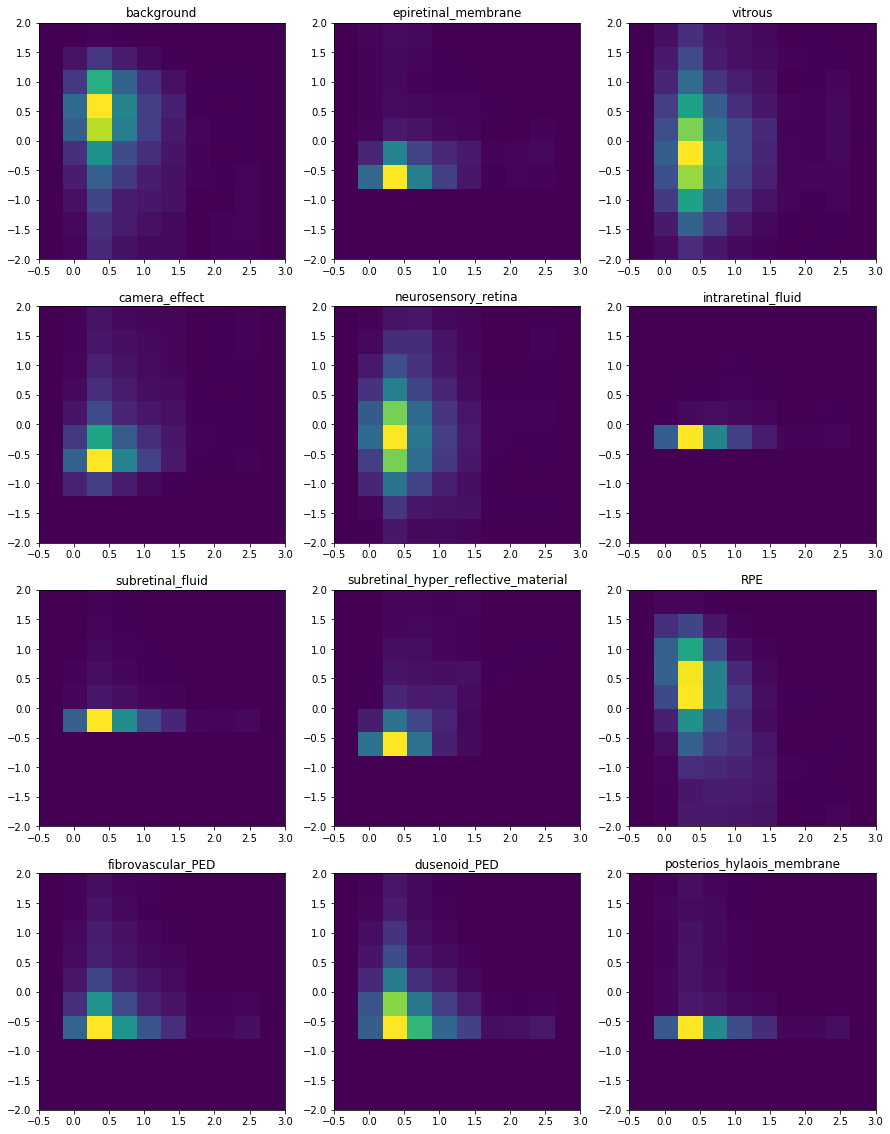

In [46]:
# plot current / next va vs feature value
fig, axes = plt.subplots(4,3, figsize=(15,20))
for i, ax in enumerate(axes.flatten()):
    feat_name = Measurement.FEATURES[i]
    ax.set_title(feat_name)
    ax.hist2d(cur_va.flatten(), norm_features[:,:,i].flatten(), range=[[-0.5,3],[-2,2]])
plt.savefig(os.path.join(fig_dir, 'currentva_va_features.png'), dpi=300)

In [ ]:
# make plot for progress report
day = [0, 100, 121]
day = [0, 40, 63, 80]
day = [0, 60, 73, 111]
logMar = [
    [1.1, 1.0, 0.6],
    [0.3, 0.4, 0.4],
    
]
injection = [
    [0, 0, 0],
    [],
    []
]
surgery = [
    [0,1,0],
    [0,0,0],
    [0,0,0]
]
# log MAR: lower is better



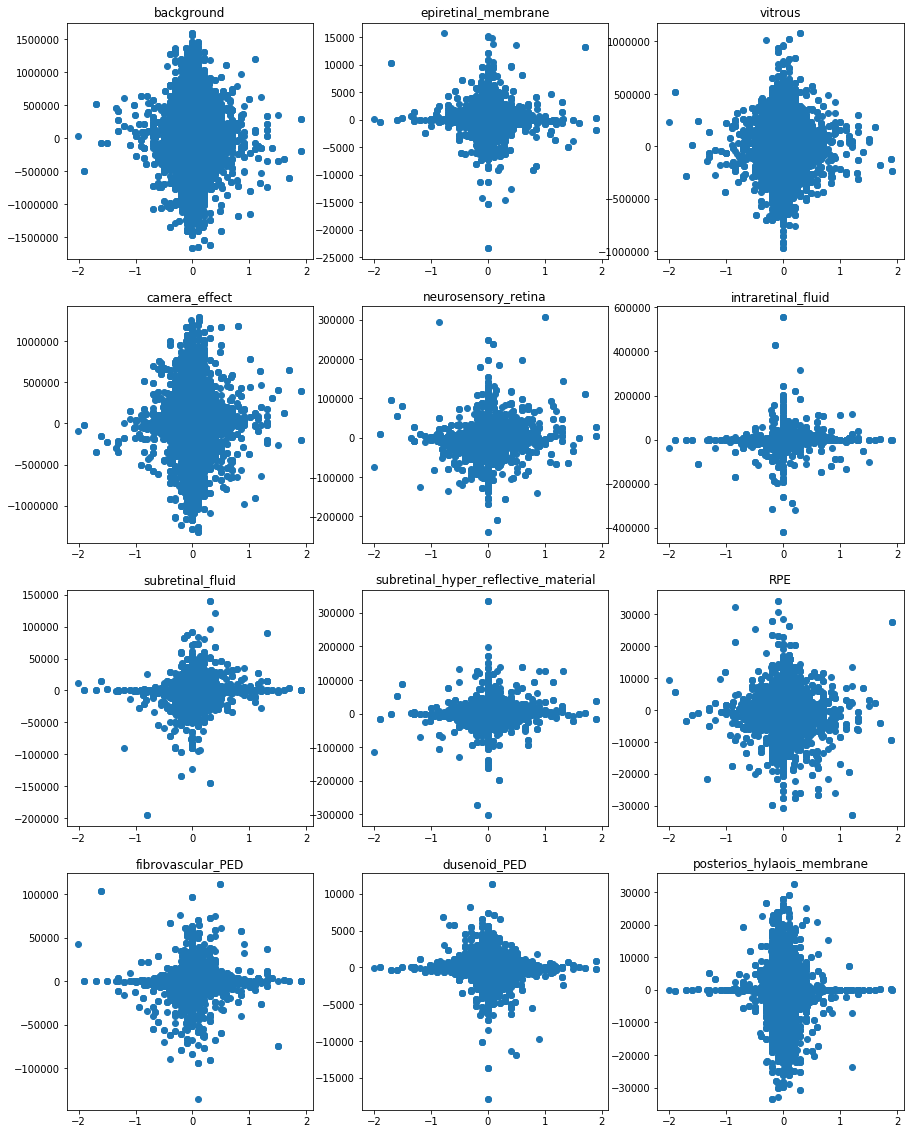

In [182]:
# plot change in va vs change in features
diff_va = cur_va[:,1:] - cur_va[:,:3]
diff_feat = features[:,1:] - features[:,:3]
fig, axes = plt.subplots(4,3, figsize=(15,20))
for i, ax in enumerate(axes.flatten()):
    feat_name = sequences.Measurement.FEATURES[i]
    ax.set_title(feat_name)
    ax.scatter(diff_va.flatten(), diff_feat[:,:,i].flatten())
plt.savefig(os.path.join(fig_dir, 'diffva_vs_difffeatures.png'), dpi=300)

static plot: correlation between RPE + visual acuity

dynamic plot: cannot see any correlations

### Plot patient trajectories including ls and inj events

In [1]:
# plot time series
def plot_trajectory(va, next_va, delta_t, injections, lens_surgery, ax=None, color=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ts = [0,] + list(np.cumsum(delta_t))
    vas = list(va.numpy()[:,0]) + list(next_va.numpy()[-1:,0])
    inj_pos = np.mean(vas)-np.std(vas)
    ls_pos = np.mean(vas)+np.std(vas)
    ax.plot(ts, vas, 'o-', color=color)
    for i,t in enumerate(ts[:-1]):
        if injections[i] > 0:
            ax.plot(t, inj_pos, '*', color=color)
        if lens_surgery[i] > 0:
            ax.plot(t, ls_pos, 's', color=color)

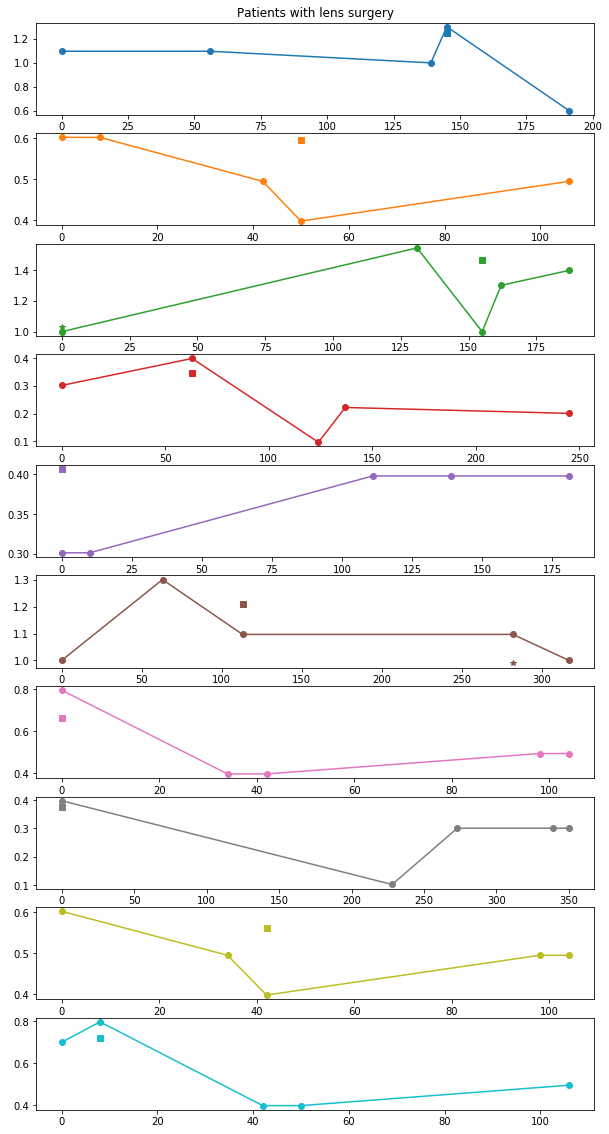

In [183]:
cmap = mpl.cm.get_cmap('tab10')
num_to_plot = 10
fig, axes = plt.subplots(10,1, figsize=(10,20))
i = 0
for el in est.val_dataset.dataset.shuffle(1000).take(1000):
    cur_va, delta_t, inj, ls, _, next_va = el
    if sum(ls) > 0:
        plot_trajectory(cur_va, next_va, delta_t, inj, ls, ax=axes[i], color=cmap(i))
        i += 1
    if i >= num_to_plot:
        break
axes[0].set_title('Patients with lens surgery')
plt.savefig(os.path.join(fig_dir, 'trajectories_random_ls.png'), dpi=300)

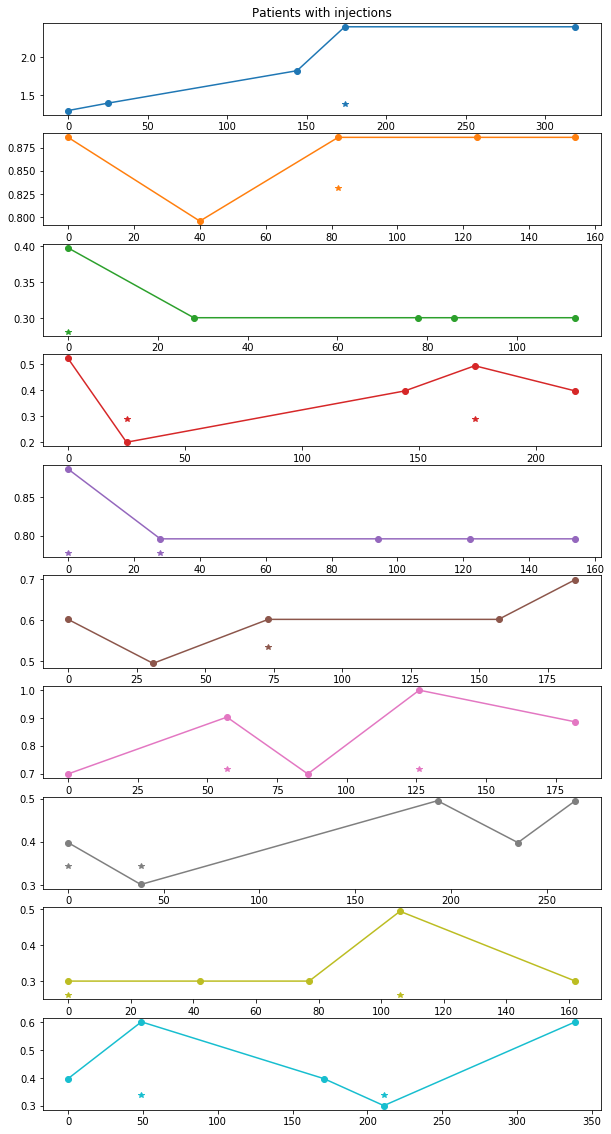

In [184]:
cmap = mpl.cm.get_cmap('tab10')
num_to_plot = 10
# plot time series
fig, axes = plt.subplots(10,1, figsize=(10,20))
i = 0
for el in est.val_dataset.dataset.shuffle(1000).take(1000):
    cur_va, delta_t, inj, ls, _, next_va = el
    if sum(inj) > 0:
        plot_trajectory(cur_va, next_va, delta_t, inj, ls, ax=axes[i], color=cmap(i))
        i += 1
    if i >= num_to_plot:
        break
axes[0].set_title('Patients with injections')
plt.savefig(os.path.join(fig_dir, 'trajectories_random_inj.png'), dpi=300)

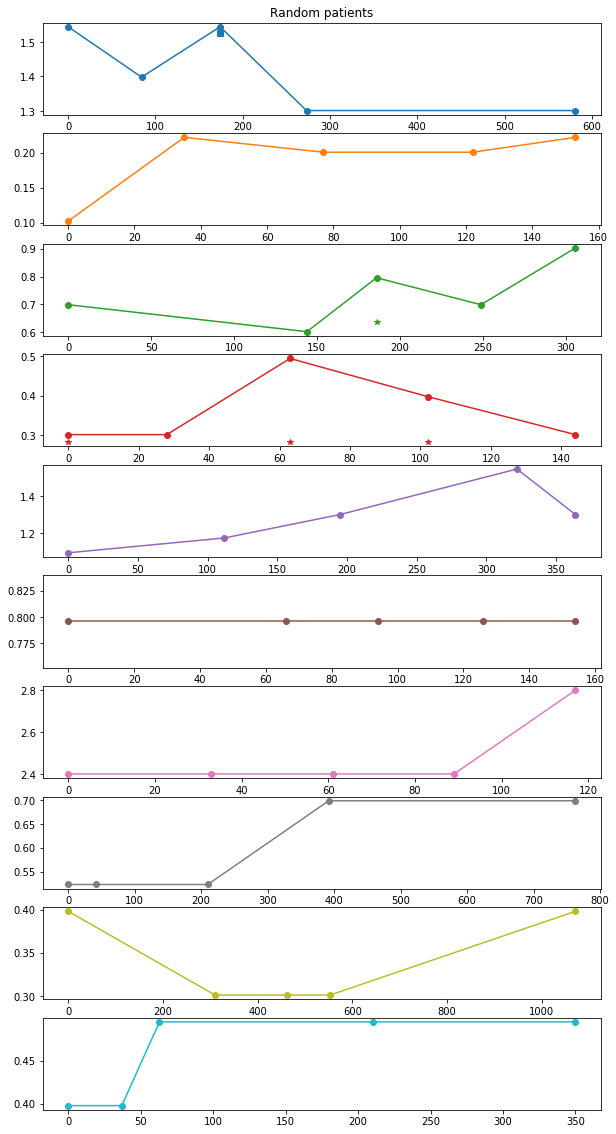

In [185]:
cmap = mpl.cm.get_cmap('tab10')
num_to_plot = 10
# plot time series
fig, axes = plt.subplots(10,1, figsize=(10,20))
i = 0
for el in est.val_dataset.dataset.shuffle(1000).take(1000):
    cur_va, delta_t, inj, ls, _, next_va = el
    plot_trajectory(cur_va, next_va, delta_t, inj, ls, ax=axes[i], color=cmap(i))
    i += 1
    if i >= num_to_plot:
        break
axes[0].set_title('Random patients')
plt.savefig(os.path.join(fig_dir, 'trajectories_random.png'), dpi=300)

## Train NNs

In [10]:
# avoid loading features each time
est_base = Estimator(default_config)
est_base.datasets_from_sequences(sequences=sequences_all)

# calculate baseline
baseline_pred, y_true = est_base.val_dataset.get_value_list([IOVar.CUR_VA, IOVar.NEXT_VA], batch_size=512)
baseline_mae = losses.mae_last_numpy(y_true, baseline_pred)

INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1, 'units': 32, 'activation': 'relu', 'log': False}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Splitting sequences of len 5 into 0.8 train, 0.1 val (seed 42)
INFO:Estimator:Split sequences in 9351 train (81.6%), 987 val (8.6%), 1124 test (9.8%)
INFO:Estimator:Loading features from ../../data/clinical_feature_segmentation/longitudinal_features_statistics.csv
/Users/hannah.spitzer/opt/miniconda3/envs/lode/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
INFO:Estimator:Adding features to sequences 0
100%|██████████| 9351/9351 [00:05<00:00, 1575.01it/s]
INFO:Estimator:Adding features to sequences 1
100%|██████████| 987/987 [00:00<00:00, 1664.77it/s]
INFO:Estimator:Adding features to sequences 2
100%|██████████| 1124/1124 [00:00<00:00, 1624.87it/s]
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T
INFO:Estimator:Calculating normalization values for var IOVar.ALL_FEATURES


In [253]:
def train_test(config, sequences_split):
    config = merged_config(default_config, config)
    config['sequence_data']['features_fname'] = None
    est = estimators.Estimator(config)
    est.sequences_split = sequences_split
    est.datasets_from_sequences()
    
    history = est.train_model(verbose=0)
    score = est.evaluate_model(est.val_dataset, verbose=0)
    prediction = est.predict_model(est.val_dataset)
    return history, score, prediction


def multiple_train_test(configs, sequences_split, save_csv=None):
    histories = {}
    scores = {}
    predictions = {}
    for name, config in configs.items():
        hist, score, pred = train_test(config, sequences_split)
        histories[name] = hist
        scores[name] = score
        predictions[name] = pred
        if save_csv is not None:
            with open(save_csv, 'a') as f:
                f.write('{}; {}\n'.format(name, hist.history))
    return histories, scores, predictions


### Compare model with features to model without features

In [241]:
configs = {
    'with features': {},
    'without features': {'model': {'norm': [None, True, None, None, None], 'input_vars': [IOVar.CUR_VA,IOVar.DELTA_T,IOVar.INJ_SHORT,IOVar.LENS_SURGERY]}}
}
histories, scores, predictions = multiple_train_test(configs, est_base.sequences_split)

INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1, 'units': 32, 'activation': 'relu', 'log': False}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1, 'units': 32, 'activation': 'relu', 'log': False}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T


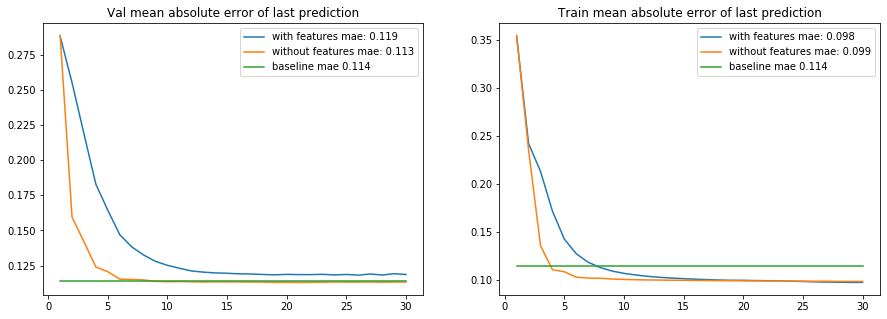

In [242]:
plot_train_curve_comparison(list(histories.values()), list(histories.keys()), baseline_mae)

performance with features is really bad ?!?

### Vary number / size of embedding, lstm, output layers

In [16]:
import estimators
import sequences
import models
import importlib
importlib.reload(estimators)
importlib.reload(sequences)
importlib.reload(models)

<module 'models' from '../models.py'>

In [252]:
for name, hist in histories.items():
    with open('hyperparams_lstm_architecture.csv', 'a') as f:
        f.write('{}; {}\n'.format(name, hist.history))

In [245]:
# create configs
configs = {}
for encoder_layers in [0,1,2]:
    for lstm_layers in [1,2]:
        for decoder_layers in [0,1]:
            name = f'{encoder_layers} enc, {lstm_layers} lstm, {decoder_layers} dec'
            config = {'model': {'model_kwargs': {'encoder_layers': {'num_layers': encoder_layers}},
                                'decoder_layers': {'num_layers': decoder_layers},
                                'lstm_layers': {'num_layers': lstm_layers}}}
            configs[name] = config

histories, scores, predictions = multiple_train_test(configs, est_base.sequences_split, save_csv='hyperparams_lstm_architecture.csv')


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 0}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 0}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 0}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 0}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 2}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 2}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 2}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 2}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


In [254]:
# even more lstm layers
# create configs
configs = {}
for encoder_layers in [0,]:
    for lstm_layers in [3,4]:
        for decoder_layers in [0]:
            name = f'{encoder_layers} enc, {lstm_layers} lstm, {decoder_layers} dec'
            config = {'model': {'model_kwargs': {'encoder_layers': {'num_layers': encoder_layers}},
                                'decoder_layers': {'num_layers': decoder_layers},
                                'lstm_layers': {'num_layers': lstm_layers}}}
            configs[name] = config

histories, scores, predictions = multiple_train_test(configs, est_base.sequences_split, save_csv='hyperparams_lstm_architecture.csv')



INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 0}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 0}, 'lstm_layers': {'num_layers': 1, 'units': 64, 'log': False}, 'decoder_layers': {'num_layers': 0, 'units': 32, 'activation': 'relu', 'log': False}}


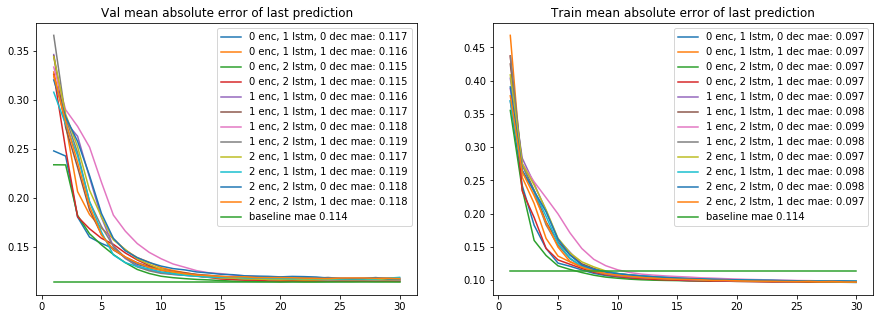

In [246]:
plot_train_curve_comparison(list(histories.values()), list(histories.keys()), baseline_mae)

### model with no embeddingi layers

In [193]:
sequences_split = est.sequences_split

In [194]:
config = {'sequence_data': {'features_fname': None}, 
          'model': { 'model_cls': models.SimpleLSTMModel, 'model_kwargs': {'num_embedding_layers':0}}}
config = merged_config(default_config, config)
est = estimators.Estimator(config)
est.sequences_split = sequences_split
est.datasets_from_sequences()
#history =  est.train_model(verbose=0)
#score = est.evaluate_model(est.val_dataset, verbose=0)
#prediction = est.predict_model(est.val_dataset)



INFO:Estimator:Creating <class 'models.SimpleLSTMModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]
INFO:Estimator:Calculating normalization values for var IOVar.DELTA_T
INFO:Estimator:Calculating normalization values for var IOVar.ALL_FEATURES


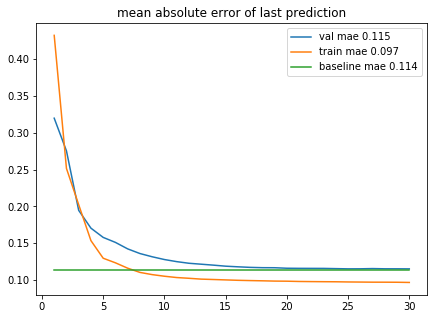

In [190]:
plot_train_curve(history, baseline_mae)

### fully connected model (no LSTM)

In [18]:
def train_test(config, sequences_split):
    config = merged_config(default_config, config)
    config['sequence_data']['features_fname'] = None
    est = estimators.Estimator(config)
    est.sequences_split = sequences_split
    est.datasets_from_sequences()
    
    history = est.train_model(verbose=1)
    score = est.evaluate_model(est.val_dataset, verbose=1)
    prediction = est.predict_model(est.val_dataset)
    return history, score, prediction

In [19]:
config = {'model': { 'model_cls': models.SimpleANNModel, 
                    'model_kwargs': {
                        'encoder_layers': {'num_layers': 1,'units': 32,'activation': 'relu'},
                        'dense_layers':{'num_layers': 1,'units': 64,'activation': 'relu'},
                        'decoder_layers': {'num_layers': 0}}}}
history, score, prediction = train_test(config, est_base.sequences_split)



INFO:Estimator:Creating <class 'models.SimpleANNModel'> model with iputs [<IOVar.CUR_VA: 1>, <IOVar.DELTA_T: 4>, <IOVar.INJ_SHORT: 5>, <IOVar.LENS_SURGERY: 7>, <IOVar.ALL_FEATURES: 8>] and outputs [<IOVar.NEXT_VA: 2>]


{'encoder_layers': {'num_layers': 1, 'units': 32, 'activation': 'relu'}, 'dense_layers': {'num_layers': 1, 'units': 64, 'activation': 'relu'}, 'decoder_layers': {'num_layers': 0}}
Epoch 1/30
19/19 [==============================] - 2s 96ms/step - loss: 0.4713 - mean_absolute_error: 0.4755 - mae_last: 0.4783 - val_loss: 0.3757 - val_mean_absolute_error: 0.3761 - val_mae_last: 0.3881
Epoch 2/30
19/19 [==============================] - 1s 64ms/step - loss: 0.3148 - mean_absolute_error: 0.3162 - mae_last: 0.3158 - val_loss: 0.3285 - val_mean_absolute_error: 0.3288 - val_mae_last: 0.3408
Epoch 3/30
19/19 [==============================] - 1s 66ms/step - loss: 0.2630 - mean_absolute_error: 0.2641 - mae_last: 0.2656 - val_loss: 0.2697 - val_mean_absolute_error: 0.2700 - val_mae_last: 0.2802
Epoch 4/30
19/19 [==============================] - 1s 66ms/step - loss: 0.2233 - mean_absolute_error: 0.2243 - mae_last: 0.2256 - val_loss: 0.2255 - val_mean_absolute_error: 0.2258 - val_mae_last: 0.2340


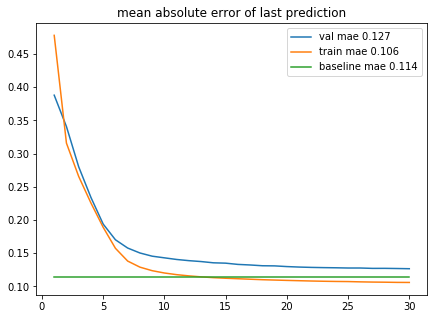

In [20]:
plot_train_curve(history, baseline_mae)

In [208]:
model_kwargs = {'encoder_layers': {'num_layers': 1,'units': 32,'activation': 'relu'},
                'dense_layers':{'num_layers': 1,'units': 64,'activation': 'relu'},
                'decoder_layers': {'num_layers': 0}}
model = models.SimpleANNModel(config['model']['input_vars'], config['model']['output_vars'], config['model']['sequence_length'], **model_kwargs)


{'encoder_layers': {'num_layers': 1, 'units': 32, 'activation': 'relu'}, 'dense_layers': {'num_layers': 1, 'units': 64, 'activation': 'relu'}, 'decoder_layers': {'num_layers': 1, 'units': 32, 'activation': 'relu'}}


In [209]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_75 (InputLayer)           [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
input_76 (InputLayer)           [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
input_77 (InputLayer)           [(None, 4, 1)]       0                                            
__________________________________________________________________________________________________
input_78 (InputLayer)           [(None, 4, 1)]       0                                            
___________________________________________________________________________________________